In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
%matplotlib inline


\begin{array}{|c|c|c|}
\hline
\text{Остальные покупки} / \text{покупки предмета } А & 0 & 40 \\
\hline
0 & a & b \\
\hline
10 & c & d \\
\hline
\end{array}

При этом вероятности попадания пользователей в группы суммируются в 1:
$$
a+b+c+d = 1
$$

Рассматрвиаем долю покупок предмета А в 2 раличных выборках размера 10000 наблюдений

### Генерация вероятностей покупки

In [88]:
def sample_users(n, a, b, c, d):
    """
    Функция для генерации n пользователей с соответствующими покупками
    """
    q = np.random.choice([1, 2, 3, 4], size=n, replace=True, p=[a, b, c, d])
    star_items = np.zeros_like(q)
    star_items = ((q==2) + (q == 4))*40
    total_items = ((q == 3) + (q == 4))*10 + ((q == 2) + (q == 4))*40
    # Total dollar value of items
    dri = np.sum((q == 3) + (q == 4)) * 10
    dsi = np.sum((q == 2) + (q == 4)) * 40
    #подсчет дисперсий, средних и корреляций
    mu1 = np.mean(star_items)
    mu2 = np.mean(total_items)
    sig1 = np.std(star_items)
    sig2 = np.std(total_items)
    cor = np.corrcoef(star_items,total_items)[0,1]
    #сохраним их в удобном виде
    norm_params = {
        'mu1':mu1,
        'mu2':mu2,
        'sig1':sig1,
        'sig2':sig2,
        'cor':cor
    }
    # Output
    return {'dri': dri, 'dsi': dsi, 'dti': dri + dsi, 'q': q, 'params': norm_params}

Альтернативный вариант приближения - использовать формулу

$$
Law(\zeta) \approx \mathcal{N}(\mu_{\zeta},\sigma_{\zeta}^2)\,, \text{ где } \mu_{\zeta} = \mu_{\xi}/\mu_{\eta}\,, \quad \sigma_{\zeta}^2 = \frac{\mu_{\xi}^2\sigma_{\eta}^2}{\mu_{\eta}^4} - \frac{2 \rho \mu_{\xi} \sigma_{\xi} \sigma_{\eta}}{\mu_{\eta}^3} + \frac{\sigma_{\xi}^2}{\mu_{\eta}^2}
$$

In [89]:
def compute_norm(mu1,mu2,sig1,sig2,rho):
    """
    Функция для подсчета параметров нормальной аппроксимации по формуле (3.78) Отчета о НИР
    Возвращаемое значение:
        mu, var - оценки среднего и дисперсии нормальной плотности
    """
    mu = mu1/mu2
    var = (mu1**2 * sig2**2) / (mu2**4) - 2*rho*mu1*sig1*sig2/(mu2**3) + sig1**2/(mu2**2)
    return mu,var

In [90]:
def approx_norm(w, mu1, mu2, sig1, sig2, rho):
    """
    Вычисление нормальной аппроксимации плотности метрики отношения по формуле (3.78) Отчета о НИР
    """
    mu,var = compute_norm(mu1,mu2,sig1,sig2,rho)
    #плотность нормального распределения с параметрами, введенными выше
    out = norm.pdf(w, loc=mu, scale=np.sqrt(var))
    return out

In [91]:
def fw(w, mu1, mu2, sig1, sig2, rho):
    """
    Вычисление нормальной аппроксимации для метрики отношения по формуле (3.74) из отчета
    """
    aw = np.sqrt(w**2/sig1**2 - 2*rho*w/(sig1*sig2) + 1/sig2**2)
    bw = w*mu1/sig1**2 - rho*(mu1+mu2*w)/(sig1*sig2) + mu2/sig2**2
    c_val = mu1**2/sig1**2 - 2 * rho * mu1 * mu2 / (sig1*sig2) + mu2**2/sig2**2
    dw = np.exp((bw**2 - c_val*aw**2)/(2*(1-rho**2)*aw**2))
  
    out = (bw*dw / (np.sqrt(2*np.pi) * sig1 * sig2 * aw**3)) * \
          (norm.cdf(bw/aw/np.sqrt(1-rho**2)) - norm.cdf(-bw/aw/np.sqrt(1-rho**2))) + \
          np.sqrt(1-rho**2)/(np.pi*sig1*sig2*aw**2) * np.exp(-c_val/(2*(1-rho**2)))
    return out

In [92]:
def fwusers(na, nb, nc, nd, n=10000):
    """
    Функция для вычисления параметров нормальной аппроксимации по заданному массиву
    """
    users = np.concatenate((np.repeat(1, na), np.repeat(2, nb), np.repeat(3, nc), np.repeat(4, nd)))
    dsi = np.array([0, 40, 0, 40])[users - 1]
    dri = np.array([0, 0, 10, 10])[users - 1]
    dti = dsi + dri

    sig1 = np.sqrt(np.var(dsi)) * np.sqrt(n)
    sig2 = np.sqrt(np.var(dti)) * np.sqrt(n)
    cor = np.corrcoef(dti, dsi)[0, 1]
    mu1 = np.mean(dsi) * n
    mu2 = np.mean(dti) * n
    return {'sig1': sig1, 'sig2': sig2, 'cor': cor, 'mu1': mu1, 'mu2': mu2}

In [93]:
#число повторений эксперимента
ntr = 10**4
#размеры контрольной и экспериментальной групп
n = 10**5
m = 10**5


# Выборка размера ntr из распределения первой группы
dsi1 = np.zeros(ntr)
dti1 = np.zeros(ntr)
params1 = []

for i in range(ntr):
    users = sample_users(n, 0.19, 0.001, 0.8, 0.009)
    dsi1[i] = users['dsi']
    dti1[i] = users['dti']
    params1.append(users['params'])

# Выборка размера ntr из распределения второй группы
dsi2 = np.zeros(ntr)
dti2 = np.zeros(ntr)
params2 =[]
for i in range(ntr):
    users = sample_users(m, 0.09, 0.001, 0.9, 0.009)
    dsi2[i] = users['dsi']
    dti2[i] = users['dti']
    params2.append(users['params'])

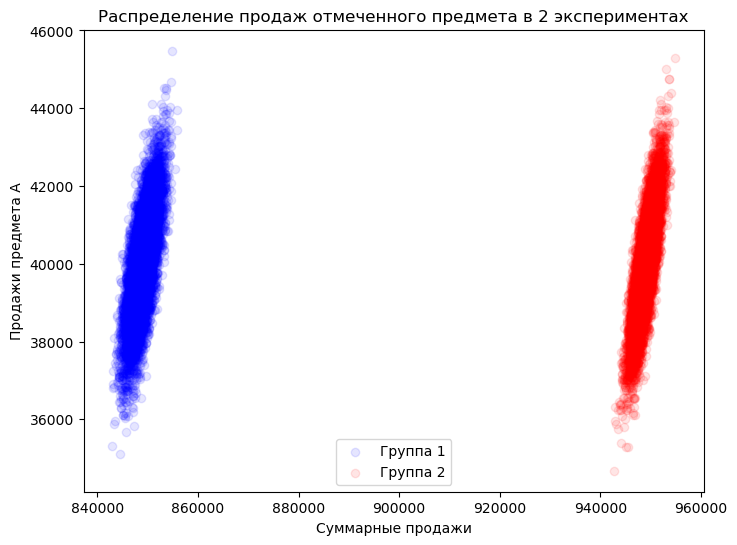

In [94]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dti1, dsi1, label='Группа 1', color='blue', alpha=0.1)
plt.scatter(dti2, dsi2, label='Группа 2', color='red', alpha=0.1)
plt.xlabel('Суммарные продажи')
plt.ylabel('Продажи предмета А')
plt.title('Распределение продаж отмеченного предмета в 2 экспериментах')
plt.legend()
plt.show()

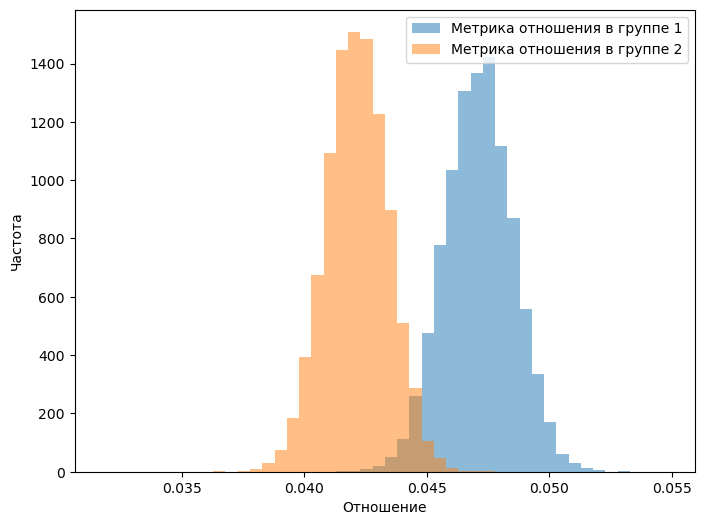

In [95]:
# Histograms for ratio
ratio1 = dsi1 / dti1
ratio2 = dsi2 / dti2
max_ratio = max(np.max(ratio1), np.max(ratio2))
min_ratio = min(np.min(ratio1), np.min(ratio2))
bins = np.arange(min_ratio - 0.005, round(max_ratio, 2) + 0.005, 0.0005)

#построение графика для статистики отношения в 2 группах
plt.figure(figsize=(8, 6))
h1, bins1, _ = plt.hist(ratio1, bins=bins, alpha=0.5, label='Метрика отношения в группе 1')
h2, bins2, _ = plt.hist(ratio2, bins=bins, alpha=0.5, label='Метрика отношения в группе 2')
plt.legend()
plt.xlabel('Отношение')
plt.ylabel('Частота')
plt.show()

### Оценим и визуализириуем точность гауссовского приближения для вышеприведенных гистограмм:

Рассмотрим для начала отношение Ratio1:

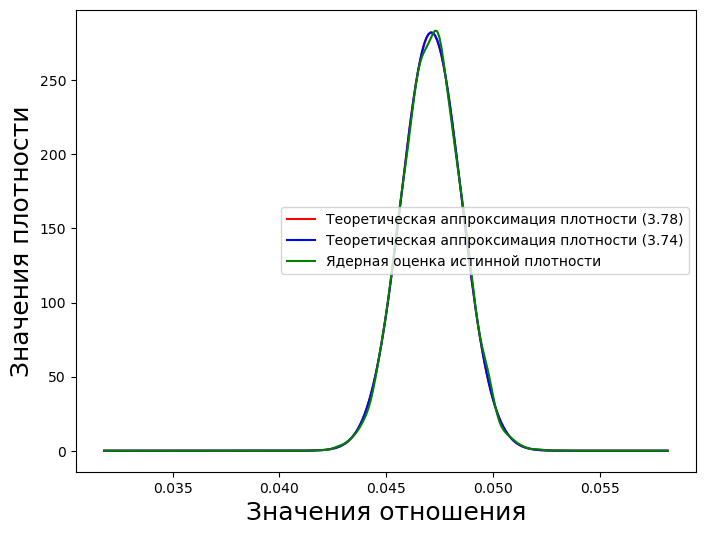

In [96]:
#точки, в которых будет вычисляться плотность
args1 = np.arange(min_ratio - 0.005, max_ratio+0.005, 0.0001)

#по данным массива ratio1 вычислим ядерную оценку плотности 
kernel1 = stats.gaussian_kde(ratio1)
#вычислим ее значения на решетке args1
vals1 = kernel1(args1)

#вычислим теоретические значения плотности, получаемые линеаризацией
wf1 = fwusers(19000,100,80000,900,100000)
dens_appr_1_1 = approx_norm(args1, wf1['mu1'], wf1['mu2'], wf1['sig1'], wf1['sig2'], wf1['cor'])
dens_appr_2_1 = fw(args1, wf1['mu1'], wf1['mu2'], wf1['sig1'], wf1['sig2'], wf1['cor'])

plt.figure(figsize=(8, 6))
plt.plot(args1, dens_appr_1_1, c = 'r', label = 'Теоретическая аппроксимация плотности (3.78)')
plt.plot(args1, dens_appr_2_1, c = 'b', label = 'Теоретическая аппроксимация плотности (3.74)')
plt.plot(args1, vals1, c = 'g', label = 'Ядерная оценка истинной плотности')
plt.xlabel('Значения отношения',fontsize=18)
plt.ylabel('Значения плотности',fontsize=18)
plt.legend()
plt.show()

Аналогичные выводы для отношения Ratio1:

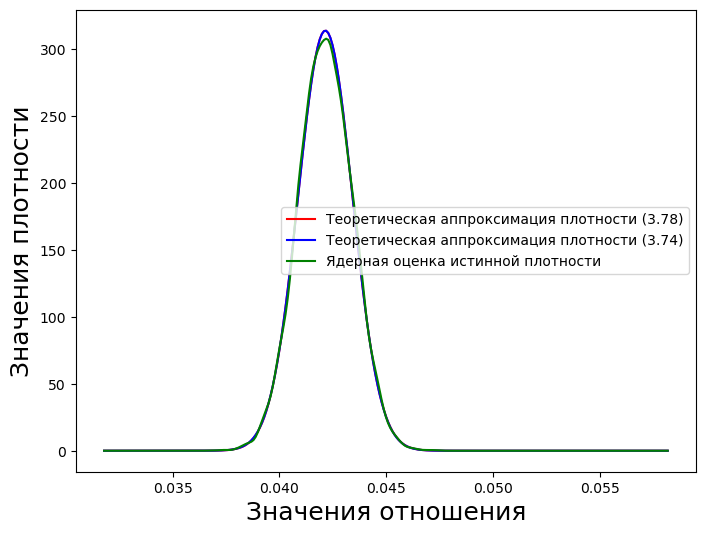

In [97]:
#по данным массива ratio1 вычислим ядерную оценку плотности 
kernel2 = stats.gaussian_kde(ratio2)
#вычислим ее значения на решетке args1
vals2 = kernel2(args1)

#вычислим теоретические значения плотности, получаемые линеаризацией
wf2 = fwusers(9000,100,90000,900,100000)

dens_appr_1_2 = approx_norm(args1, wf2['mu1'], wf2['mu2'], wf2['sig1'], wf2['sig2'], wf2['cor'])
dens_appr_2_2 = fw(args1, wf2['mu1'], wf2['mu2'], wf2['sig1'], wf2['sig2'], wf2['cor'])

plt.figure(figsize=(8, 6))
plt.plot(args1, dens_appr_1_2, c = 'r', label = 'Теоретическая аппроксимация плотности (3.78)')
plt.plot(args1, dens_appr_2_2, c = 'b', label = 'Теоретическая аппроксимация плотности (3.74)')
plt.plot(args1, vals2, c = 'g', label = 'Ядерная оценка истинной плотности')
plt.xlabel('Значения отношения',fontsize=18)
plt.ylabel('Значения плотности',fontsize=18)
plt.legend()
plt.show()

### Вычисление мощности эксперимента

In [98]:
print(np.mean(ratio1))
print(np.mean(ratio2))

0.04712939108093533
0.042153409061930554


In [99]:
#фиксируем рассматриваемую величину эффекта D в соответствии с формулой (3.82)
D = np.mean(ratio1) - np.mean(ratio2)
#высчитывает величину дисперсии в соответствии с формулой (3.81) отчета
_, sigma_squared_1 = compute_norm(wf1['mu1'], wf1['mu2'], wf1['sig1'], wf1['sig2'], wf1['cor'])
_, sigma_squared_2 = compute_norm(wf2['mu1'], wf2['mu2'], wf2['sig1'], wf2['sig2'], wf2['cor'])
sigma_fin = sigma_squared_1/n + sigma_squared_2/m
#расчет критического значения 
alpha = 0.05
crit_val = norm.ppf(1-alpha/2)

#массив значений тестовой статистики
stat_vals = []

for i in range(ntr):
    _,sigma_squared_1 = compute_norm(params1[i]['mu1'], params1[i]['mu2'], params1[i]['sig1'], params1[i]['sig2'], params1[i]['cor'])
    _,sigma_squared_2 = compute_norm(params2[i]['mu1'], params2[i]['mu2'], params2[i]['sig1'], params2[i]['sig2'], params2[i]['cor'])
    sigma_fin = sigma_squared_1/n + sigma_squared_2/m
    test_val = np.abs(ratio1[i] - ratio2[i]) / np.sqrt(sigma_fin)
    stat_vals.append(test_val)

In [100]:
_, sigma_squared_1 = compute_norm(wf1['mu1'], wf1['mu2'], wf1['sig1'], wf1['sig2'], wf1['cor'])
_, sigma_squared_2 = compute_norm(wf2['mu1'], wf2['mu2'], wf2['sig1'], wf2['sig2'], wf2['cor'])
sigma_fin = sigma_squared_1 + sigma_squared_2

print("достигнутая мощность эксперимента: ", np.sum(stat_vals > crit_val) / ntr)
print("ожидаемая мощность эксперимента (в соответствии с формулой 3.86 Отчета о НИР): ", norm.cdf(D/np.sqrt(sigma_fin) - crit_val) + norm.cdf(-D/np.sqrt(sigma_fin) - crit_val))

достигнутая мощность эксперимента:  0.7453
ожидаемая мощность эксперимента (в соответствии с формулой 3.86 Отчета о НИР):  0.7449037543730148
